---
## Step 0: Load & Setup The Data

In [1]:
# general python packages
from __future__ import print_function
import os 
import glob
import math
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt

# Deep Learning packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling3D, AveragePooling3D, Input, ZeroPadding3D
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, Adadelta, RMSprop, Adamax, Nadam, SGD # using Adam in this model, but just showing the other options here for future reference
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [4]:
# neuroimaging-specific python packages
import nilearn
from nilearn import plotting
import nibabel as nib

In [ ]:
# Connect to Google Drive where data is stored
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/OHBM_DL_data/'

In [5]:
# Read in csv file with subject info
pheno = pd.read_csv('/net/parasite/CMI/OHBM_DL_data/pheno_file.csv')

In [15]:
pheno['Age'].describe()

count    906.000000
mean      10.824074
std        3.558937
min        5.036048
25%        8.039898
50%       10.031599
75%       13.057266
max       21.816563
Name: Age, dtype: float64

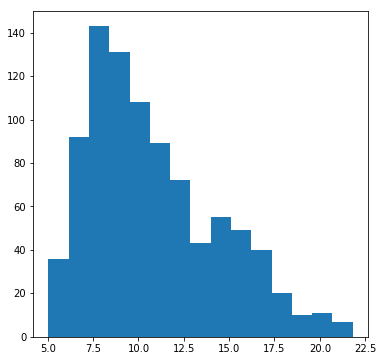

In [54]:
plt.figure(figsize=(6,6))
plt.hist(pheno['Age'],bins=15)
plt.show()

In [17]:
# Create numpy array of age labels for all subjects
age_all = pheno['Age'].to_numpy()

In [5]:
cd /net/parasite/CMI/OHBM_DL_data/

/net/parasite/CMI/OHBM_DL_data


In [6]:
def ConvertGMNIItoNPY(inFile, outFile, SubjectDataFrame):
    for _, row in SubjectDataFrame.iterrows():
        subject = row['Subject']
        #print('Saving Subject {}'.format(subject))
        fileName = '{}{}_GMprobmask.nii'.format(inFile, str(subject))
        NIIimage = nib.load(fileName)
        imageArray = NIIimage.get_data()
        outFileName = outFile + str(subject)
        np.save(outFileName, imageArray)

In [7]:
def ConvertWMNIItoNPY(inFile, outFile, SubjectDataFrame):
    for _, row in SubjectDataFrame.iterrows():
        subject = row['Subject']
        #print('Saving Subject {}'.format(subject))
        fileName = '{}{}_WMprobmask.nii'.format(inFile, str(subject))
        NIIimage = nib.load(fileName)
        imageArray = NIIimage.get_data()
        outFileName = outFile + str(subject)
        np.save(outFileName, imageArray)

In [8]:
def ConvertCSFNIItoNPY(inFile, outFile, SubjectDataFrame):
    for _, row in SubjectDataFrame.iterrows():
        subject = row['Subject']
        #print('Saving Subject {}'.format(subject))
        fileName = '{}{}_CSFprobmask.nii'.format(inFile, str(subject))
        NIIimage = nib.load(fileName)
        imageArray = NIIimage.get_data()
        outFileName = outFile + str(subject)
        np.save(outFileName, imageArray)

In [10]:
SubjectDataFrame = pheno
ConvertGMNIItoNPY(inFile='/net/parasite/CMI/OHBM_DL_data/tissue_masks/resampled/', outFile='/net/parasite/CMI/OHBM_DL_data/rs_GMnumpyArrays/', SubjectDataFrame=SubjectDataFrame)

In [11]:
SubjectDataFrame = pheno
ConvertWMNIItoNPY(inFile='/net/parasite/CMI/OHBM_DL_data/tissue_masks/resampled/', outFile='/net/parasite/CMI/OHBM_DL_data/rs_WMnumpyArrays/', SubjectDataFrame=SubjectDataFrame)

In [14]:
SubjectDataFrame = pheno
ConvertCSFNIItoNPY(inFile='/net/parasite/CMI/OHBM_DL_data/tissue_masks/resampled/', outFile='/net/parasite/CMI/OHBM_DL_data/rs_CSFnumpyArrays/', SubjectDataFrame=SubjectDataFrame)

In [21]:
GM_input_dir = 'rs_GMnumpyArrays/'
input_names = [name for name in os.listdir(GM_input_dir)]
WM_input_dir = 'rs_WMnumpyArrays/'
CSF_input_dir = 'rs_CSFnumpyArrays/'
all_subs = []
for idx, name in enumerate(input_names):
    GM_name = GM_input_dir + name
    sub_GM = np.load(GM_name)
    WM_name = WM_input_dir + name
    sub_WM = np.load(WM_name)
    CSF_name = CSF_input_dir + name
    sub_CSF = np.load(CSF_name)
    sub_stacked = np.stack((sub_GM, sub_WM, sub_CSF), axis=3)
    all_subs.append(sub_stacked)    

In [22]:
all_subs_array = np.asarray(all_subs)

# Check input shape
### all_subs_array.shape[0] = batch size (number of subjects)
### all_subs_array.shape[1] = rows (x)
### all_subs_array.shape[2] = columns (y)
### all_subs_array.shape[3] = depth (z)
### all_subs_array.shape[4] = channels (number of segmentations)

In [23]:
all_subs_array.shape

(906, 48, 60, 46, 3)

# Check shape of labels

In [24]:
age_all.shape

(906,)

# Divide data into train/test sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(all_subs_array, age_all, test_size=0.2, random_state=42)

In [26]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape

In [27]:
print("Number of training examples =", n_train)
print ("Number of test examples", n_test)
print("Image data shape =", image_shape)

Number of training examples = 724
Number of test examples 182
Image data shape = (48, 60, 46, 3)


In [28]:
X_train, y_train = shuffle(X_train, y_train)

In [29]:
X_test, y_test = shuffle(X_test, y_test)

In [30]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_CMI_T1w_age_6-1-19'

# Step 1: Model Construction

In [34]:
with K.tf.device('/gpu:1'):
    config = tf.ConfigProto( device_count = {'GPU': 1} )
    sess = tf.Session(config=config)
    K.set_session(sess)

In [31]:
model = Sequential() # The simplest model, a linear stack of layers

model.add(Conv3D(filters=64,
                 kernel_size=(3,3,3), #determines the width, height, depth of the 3D convolution window
                 activation='elu', #Exponential Linear Unit
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform', 
                 input_shape=image_shape)) # only the first layer needs to be told this info
model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=64, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2))) # pooling is also referred to as a downsampling layer
model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch (aka make the mean activation close to 0 and the activation standard deviation close to 1)

model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=32, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=16, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=16, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(filters=8, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(Conv3D(filters=8, kernel_size=(3,3,3), activation='elu', strides=(1,1,1), padding='same'))
model.add(MaxPooling3D((2,2,2),strides=(2,2,2)))
model.add(BatchNormalization())

model.add(AveragePooling3D((2,2,2),strides=(2,2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='features')) #convert the output of the convolutional part of the CNN into a 1D feature vector. Length of vector = n_classes
model.add(Dense(1)) # final output is a single number (Age in this model)
model.summary()

filename="best_weights.h5"
filename2="weights.{epoch:02d}-{val_loss:.2f}.hdf5"


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 48, 60, 46, 64)    5248      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 24, 30, 23, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 30, 23, 64)    256       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 24, 30, 23, 32)    55328     
_________________________________________________________________
conv

In [32]:
checkpoints = []

if not os.path.exists('Results00/'):
    os.makedirs('Results00/')

checkpoints.append(ModelCheckpoint('Results00/'+filename, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=True, 
                                   mode='auto', 
                                   period=1))

checkpoints.append(ModelCheckpoint('Results00/'+filename2, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=False, 
                                   save_weights_only=True, 
                                   mode='auto', 
                                   period=20))

checkpoints.append(TensorBoard(log_dir='Results00/TensorBoardLogs', 
                               histogram_freq=0, 
                               write_graph=True, 
                               write_images=False, 
                               embeddings_freq=0, 
                               embeddings_layer_names=['features'], 
                               embeddings_metadata='metadata.tsv'))

checkpoints.append(EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10))
checkpoints.append(ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0))
checkpoints.append(CSVLogger('Results00/log.csv'))

In [33]:
model.compile(loss='mse', # the objective that the model will try to minimize
              optimizer='adam', 
              metrics=['mae', 'acc']) # add in any other metrics you want to use to show performance of the model

**Saving/loading whole models (architecture + weights + optimizer state):**
1. the architecture of the model, allowing to re-create the model
2. the weights of the model
3. the training configuration (loss, optimizer)
4. the state of the optimizer, allowing to resume training exactly where you left off


# Step 2: Model Training

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [34]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [35]:
NUM_EPOCHS = 30 # defines for how many times the training will repeat. 1 epoch is 1 forward pass and 1 backward pass over all the training examples
BATCH_SIZE= 20 # the number of training examples in one forward/backward pass (or for 1 epoch)
history1= model.fit(X_train, y_train, 
          validation_split=0.1,
          batch_size= BATCH_SIZE, 
          epochs = NUM_EPOCHS,
          callbacks=checkpoints)

Instructions for updating:
Use tf.cast instead.
Train on 651 samples, validate on 73 samples
Epoch 1/30
651/651 [==============================] - 31s 48ms/step - loss: 63.5485 - mean_absolute_error: 6.6958 - acc: 0.0000e+00 - val_loss: 100.6489 - val_mean_absolute_error: 9.3710 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 100.64893, saving model to Results00/best_weights.h5
Epoch 2/30
651/651 [==============================] - 23s 36ms/step - loss: 12.9869 - mean_absolute_error: 2.9688 - acc: 0.0000e+00 - val_loss: 77.4324 - val_mean_absolute_error: 8.0488 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 100.64893 to 77.43236, saving model to Results00/best_weights.h5
Epoch 3/30
651/651 [==============================] - 23s 36ms/step - loss: 12.8644 - mean_absolute_error: 2.9840 - acc: 0.0000e+00 - val_loss: 20.9036 - val_mean_absolute_error: 3.9944 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 77.43236 to 20.90364, saving model to Results0

# Step 3: Model Testing

In [38]:
model.evaluate(x=X_test, y=y_test)

182/182 [==============================] - 4s 21ms/step


[20.82239742069454, 3.3296790908981158, 0.0]

In [39]:
log_dir ='Results00/'
from os.path import exists, join
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_test)

# Step 4: Save Model

In [44]:
model.save('Results00/SavedModel.h5')

In [ ]:
model.predict_on_batch(x)

# Step 5: Load Pre-Trained Model, Compile, Evaluate

In [41]:
from keras.models import load_model

In [47]:
pretrain_model = load_model('Results00/SavedModel.h5')

In [48]:
pretrain_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 48, 60, 46, 64)    5248      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 48, 60, 46, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 24, 30, 23, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 30, 23, 64)    256       
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 24, 30, 23, 32)    55328     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 24, 30, 23, 32)    27680     
__________